# LMS Exploration | 3. Cat_Whiskers Sticker 

---

**[introduce]**
* 얼굴인식 카메라 스티커앱을 만들어보자.
* 얼굴을 인식하여 양 볼에 고양이 수염 스티커를 붙이는 것이 목표이다.
* 더 나아가 각도 변화가 가능하고, 거리 변화에 강건한 스티커까지 만들어보자.

**[Preparation]**
* cat-whisker.png 이미지와, 고양이 수염 스티커를 적용할 셀카 이미지를 폴더에 저장한다.


* Dlib는 ibug 300-W 데이터셋으로 학습한 pretrained model을 제공한다.
* landmark localization 을 이용하기 위해 Dlib 에서 제공하는 pretrained model의 weight file을 다운로드한다.
* 해당 모델파일은 bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용한다.


---

## 1. Preparation

In [1]:
! pip install opencv-python
! pip install cmake
! pip install dlib

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 2. 라이브러리 불러오기 | Import Library

In [2]:
import cv2 #- 이미지 처리
import matplotlib.pyplot as plt #- 노트북에 이미지 출력
import numpy as np
import os
import dlib

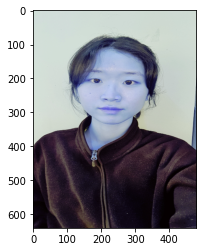

In [3]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/front.png'
img_bgr = cv2.imread(my_image_path) #- OpenCV로 이미지를 읽고
img_bgr = cv2.resize(img_bgr, (480, 640)) #- 480x640의 크기로 Resize 한다.
img_show = img_bgr.copy() #- 출력용 이미지 별도 보관 
plt.imshow(img_bgr)
# plt.axis('off') 로 축 안보이게 하기
plt.show()

* **왜 이미지의 얼굴 색에 원본 사진과 다르게 푸른빛이 돌까?** 

    matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB 순으로 사용하지만, openCV는 예외적으로 BGR을 사용한다.  
    이 때문에, openCV로 읽어온 원본사진에서 matplotlib로 출력할 때, 붉은색(R)이 푸른색(B)으로, 푸슨색은 붉은색으로 바뀌어서 출력된 것이다.  
    따라서, openCV에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 **색깔 보정처리**를 해줘야 한다. 

## 3. 색보정처리 | Convert Color BGR2RGB
* openCV에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하기위해 BGR에서 RGB로 채널을 변환함

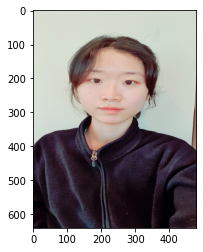

In [4]:
#- RGB 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 4. 얼굴 검출 | Face Detection

* **dlib**의 **face detector**는 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾음.

    이미지에서 그래디언트(gradient)를 특징(feature)으로 사용하는 이유는,  
    픽셀의 RGB 값 자체보다는 인접한 픽셀들 사이의 색상 변화율 자체에 오브젝트의 특징이 더욱 정확히 반영될 때가 많기 때문이다. 

In [5]:
#- hog detector 선언 
import dlib
detector_hog = dlib.get_frontal_face_detector() #- 인스턴스 생성 및 할당


#- bounding box 추출 
dlib_rects = detector_hog(img_rgb, 1) #- (image, num of img pyramid)

* **number of img pyramid** : detector_hog의 두번째 parameter로서 이미지 피라미드의 수를 나타냄.   
    이미지 피라미드란 이미지를 upsamplig 방법을 통해 크기를 키우는 것으로,   
    이미지 피라미드에서 얼굴을 다시 검출하면 작체 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능하다.

rectangles[[(139, 160) (324, 345)]]


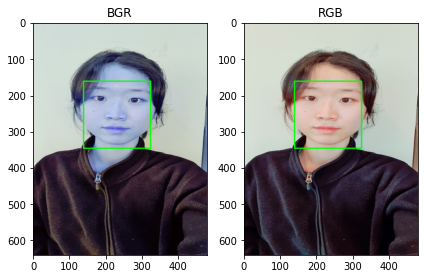

In [6]:
print(dlib_rects) #- 찾은 얼굴 영역 좌표 출력 [[(left, top) (right, bottom)]]


for dlib_rect in dlib_rects: 
    l = dlib_rect.left() #- class detector_hog 안에 있는 메서드 호출
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) #- cv2.rectangle(img, start, end, color, thickness)

    

plt.show()


#- RGB 색상 변환
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.show()

plt.subplot(121)
plt.imshow(img_show)
plt.title('BGR')
plt.subplot(122)
plt.imshow(img_show_rgb)
plt.title('RGB')
plt.tight_layout()
plt.show()

* **cv2.rectangle(img, start, end, color, thickness)**    
    top-left corner와 bottom-right corner점을 연결하는 사각형을 그린다.

    **[Parameters]**  
    img : 그림을 그릴 이미지 -> img_show   
    start : 시작 좌표 -> (l,t)  
    end : 종료 좌표 -> (r,b)  
    color : BGR형태의 Color ->(0,255,0) green  
    thickness (int) : 선의 두께. pixel -> 2  

## 5. 얼굴 랜드마크 Face Landmark
* 스티커를 섬세히 적용하기 위하여 이목구비의 위치를 추론하는 것을 **Face Landmark Localization** 이라고 함.   
* 우리는 객체(이목구비)의 위치를 추론(object keypoint estimation)하기 위해서, **top-down 방식**을 사용함.
* top-down 방식은 Bounding Box를 찾고 box 내부의 object keypoint 를 예측함.
* keypoint를 찾는 다른 알고리즘인 bottom-down 방식은 이미지 전체의 keypoint를 먼저 찾고, point 관계를 이용해 군집화하여 box를 생성함.         


* Dlib은 ibug 300-W 데이터셋으로 학습한 pretrained model 을 제공함.
* 학습 알고리즘은 regression tree의 앙상블 모델임. 

### 5-1. Dlib 에서 제공하는 pretrained model의 weight file 다운로드


In [7]:
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
! cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

--2021-07-25 07:30:46--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  16.3MB/s    in 3.7s    

2021-07-25 07:30:50 (16.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file ./models/shape_predictor_68_face_landmarks.dat already exists.


### 5-2. landmark 모델 불러오기
* landmark_predictor는 RGB 이미지와 dlib.rectangle을 입력받아 dlib.full_object_detection을 반환함. 

In [8]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path) #- 인스턴스 생성 및 할당

In [9]:
#- landmark 찾기
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) #- 클래스 호출(image, box)
    print((points))
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    print(list_points)
    list_landmarks.append(list_points)
    print(list_landmarks)

print(len(list_landmarks[0]))

points.parts()
type(points.parts())

[(134, 209), (132, 232), (133, 253), (137, 275), (145, 295), (160, 312), (177, 327), (195, 340), (217, 346), (240, 345), (264, 337), (285, 325), (305, 310), (319, 290), (328, 268), (335, 245), (338, 221), (150, 185), (163, 175), (180, 173), (198, 176), (215, 182), (252, 185), (272, 180), (292, 180), (311, 185), (324, 198), (231, 207), (230, 223), (228, 238), (226, 253), (205, 265), (215, 267), (226, 269), (238, 268), (249, 267), (165, 206), (177, 202), (191, 203), (202, 212), (189, 213), (176, 212), (264, 216), (276, 208), (289, 208), (301, 213), (289, 218), (276, 218), (187, 288), (203, 286), (216, 283), (225, 286), (235, 284), (249, 288), (265, 292), (248, 300), (233, 304), (223, 304), (213, 302), (201, 297), (193, 289), (215, 290), (225, 292), (234, 291), (259, 292), (234, 292), (224, 292), (215, 291)]
[[(134, 209), (132, 232), (133, 253), (137, 275), (145, 295), (160, 312), (177, 327), (195, 340), (217, 346), (240, 345), (264, 337), (285, 325), (305, 310), (319, 290), (328, 268), (

dlib.points

**[코드 이해하기]**    

**list_points = list(map(lambda p: (p.x, p.y), points.parts()))**

* map(함수, 리스트) : map은 리스트의 요소를 지정된 함수로 처리해주는 함수.  
     map의 첫번째 인자인 함수는 lambda p: (p.x, p.y) 이고, 두번째 인자인 리스트는 points.parts()
    
* dlib.full_object_detection object인 points에 parts()함수를 적용한 값에 접근하는 방식으로서 (p.x, p.y)

* class dlib.image_dataset_metadata.parts :
    This object is a dictionary mapping string names to object part locations.
* print(points)의 type은  <dlib.full_object_detection object at 0x7ff38ba2fef0>
  
  
* points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있다.
* 따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 된다.
* 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장된다. 



* dlib.shape_predictor  
    This object is a tool that takes in an image region containing some object and outputs a set of point locations that define the pose of the object.

    참고 : [dlib.shape_predictor](http://dlib.net/python/index.html#dlib.point)

[[(134, 209), (132, 232), (133, 253), (137, 275), (145, 295), (160, 312), (177, 327), (195, 340), (217, 346), (240, 345), (264, 337), (285, 325), (305, 310), (319, 290), (328, 268), (335, 245), (338, 221), (150, 185), (163, 175), (180, 173), (198, 176), (215, 182), (252, 185), (272, 180), (292, 180), (311, 185), (324, 198), (231, 207), (230, 223), (228, 238), (226, 253), (205, 265), (215, 267), (226, 269), (238, 268), (249, 267), (165, 206), (177, 202), (191, 203), (202, 212), (189, 213), (176, 212), (264, 216), (276, 208), (289, 208), (301, 213), (289, 218), (276, 218), (187, 288), (203, 286), (216, 283), (225, 286), (235, 284), (249, 288), (265, 292), (248, 300), (233, 304), (223, 304), (213, 302), (201, 297), (193, 289), (215, 290), (225, 292), (234, 291), (259, 292), (234, 292), (224, 292), (215, 291)]]
1


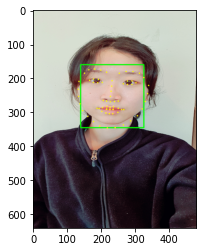

In [10]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points): #- list_points는 랜드마크 좌표의 튜플리스트
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
print(list_landmarks) #- list_points의 요소들은 (x,y) 튜플 쌍으로 이뤄짐.
print(len(list_landmarks))

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

* **cv2.circle(img, center, radian, color, thickness)**  

    **[Parameters]**  
    img : 그림을 그릴 이미지  
    center : 원의 중심 좌표(x, y)  
    radian : 반지름  
    color : BGR형태의 Color  
    thickness : 선의 두께, -1 이면 원 안쪽을 채움 

## 6. 스티커 적용 위치 확인하기 

* 랜드마크를 기준으로 '눈썹 아래 두 볼' 에 스티커를 씌워야 함. 
* 얼굴 위치, 카메라의 거리에 따라 픽셀 x가 다르기 때문에 **비율**로 계산을 해줘야 함.

In [11]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    
    print (landmark[30]) # nose center index : 30
    
    x = landmark[30][0]
    y = landmark[30][1]
    
    w =  dlib_rect.width() + (landmark[30][0] - landmark[2][0])
    h =  dlib_rect.width() #- landmark[48][1]-landmark[36][1]
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(226, 253)
(x,y) : (226,253)
(w,h) : (279,186)


* x, y 는 스티커의 좌표값, w, h 는 스티커의 너비와 높이

* zip(*iterables)  
각 iterables 의 요소들을 모으는 이터레이터를 만든다.   
튜플의 이터레이터를 돌려주는데, i 번째 튜플은 각 인자로 전달된 시퀀스나 이터러블의 i 번째 요소를 포함한다.  
단 이터레이터는 가장 짧은 입력 이터러블이 모두 소모되면 멈춘다. 

<function matplotlib.pyplot.show(close=None, block=None)>

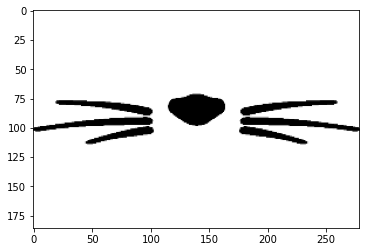

In [12]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)

img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show

In [13]:
#- 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정
refined_x = x - w // 2  # left
refined_y = y - h //2     # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (87,160)


In [14]:
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
elif refined_x < 0:
    img_sticker = img_sticker[-refined_x:]
    refined_x = 0
    

print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(186, 279, 3)
(x,y) : (87,160)


* opencv 데이터는 numpy ndarray 형태의 데이터를 사용 하는데, ndarray는 음수 인덱스에 접근할 수 없다.   
때문에, x 또는 y 좌표가 음수일 때, -x 또는 -y만큼 이미지를 잘라준 후 x 또는 y 경계값을 0으로 설정해준다.

## 7. 스티커 적용하기 

스티커를 자연스럽게 보이도록 스티커 뒤로 원본이미지가 같이 보이도록 만들어보자. 


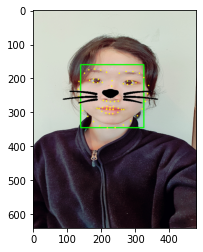

In [15]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker == 255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

---

**[코드 이해하기]**

**img_show[refined_y:refined_y+img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[0]] = \  
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)**  
    
  * 코드가 길어질 때, 역슬래쉬 \\를 사용하면 줄바꿈하여 이어쓸 수 있다.(가독성 UP!)  
  * **numpy.where(condition[, x, y])** 는 조건에 따라 x 또는 y에서 선택된 요소를 반환한다. 
  * img_show = img_bgr.copy() 를 기억하자! img_show에서 원하는 스티커 이미지의 영역에 np.where 조건문에 따라 값을 할당한다.  
  * numpy.where(condition[, x, y])는 조건에 따라 x 또는 y에서 선택된 요소를 반환한다.
  * 위 식에서 조건문은 **img_sticker==255** 이고, 조건에 만족(True)하면 sticker_area의 값을, 조건에 불문족(False)하면 img_sticker의 값을 반환한다.
      * NumPy에서 연산자 == 는 np.equal() 함수와 동일한 기능을 하므로, **element-wise 한 비교연산**을 수행한다.
      * img_sticker==255 에서 img_sticker는 스티커이미지의 rgb channel의 각 픽셀값을 담고 있으므로,   
      NumPy의 broadcast가 적용된 것으로, img_sticker==(255, 255, 255) 로 해석된다. rgb 채널에서 (255, 255, 255)는 하얀색을 의미한다.
      * 따라서 위 조건문의 의미는, img_sticker==(255, 255, 255)를 각 색상별(r,g,b)로 비교연산하여, 만족(True)하는 경우에는 sticker_area의 색상값을 할당하고, 불만족(False)인 경우에는 img_sticker의 색상값을 할당한다.  
      
      
      

**[잘 이해했는지 확인해보기]**  
img_show[refined_y:refined_y+img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[0]] = \    
    np.where(img_sticker==(0, 255, 0),sticker_area,img_sticker).astype(np.uint8)  
* 위와 같이 np.where의 조건문을 변경했을 때, img_show에서 스티커이미지의 영역이 어떻게 나타날지 생각해보자.  


 * img_sticker==(0,255,0) 의 각 픽셀의 색상값은 대부분 (False, True, False) 를 반환한다.
 * True 에는 sticker_area의 색상값을, False 에는 img_sticker의 색상값을 할당한다.
 * 이때, print(img_sticker) 를 출력해보면 각 픽셀의 색상값은 대부분 (255, 255, 255)이고, print(sticker_area)에서 색상 b의 값은 대략 200~250 사이였다. 
 * 조건문에 따라 각 픽셀의 색상값을 조합해보면 (r, g, b) = (255, 200~250, 255) 가 나온다. 색상표에 입력해보면 핑크빛 마젠타 색상이 나타난다. 
 * 마지막으로, 직접 위 코드를 실행해보면, 스티커이미지의 영역이 전체적으로 마젠타 색상을 띄고 있다는 것을 발견할 수 있다! 



**[참고]**   
[np.equal()](https://numpy.org/doc/stable/reference/generated/numpy.equal.html)  
[np.where()](https://numpy.org/doc/stable/reference/generated/numpy.where.html?highlight=where#numpy.where)

---    

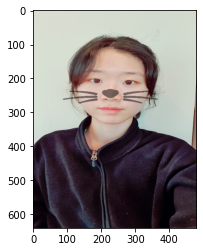

In [16]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

* **cv.addWeighted(	src1, alpha, src2, beta, gamma[, dst[, dtype]]	)**  
Calculates the weighted sum of two arrays.  
참고 : [cv.addWeighted](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#gafafb2513349db3bcff51f54ee5592a19)



## 8. 문제점 찾아보기
* 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해보자
* 문제점이 무엇인지 자세히 기록해보자

### 8-1. 멀리서 촬영하기

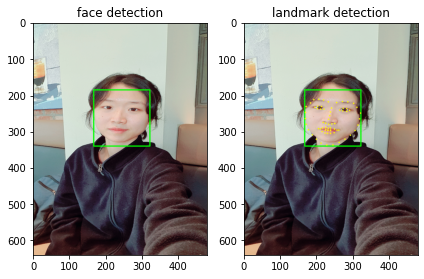

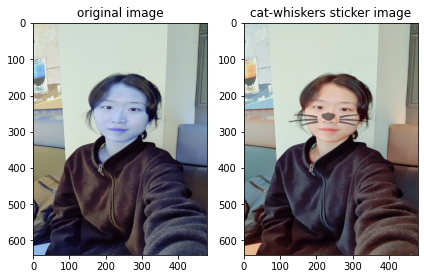

In [17]:
import cv2 #- 이미지 처리
import matplotlib.pyplot as plt #- 노트북에 이미지 출력
import numpy as np
import os
import dlib

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/far.png'
img_bgr = cv2.imread(my_image_path) 
img_bgr = cv2.resize(img_bgr, (480, 640)) 
img_origin=img_bgr.copy()
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detector_hog = dlib.get_frontal_face_detector() 
dlib_rects = detector_hog(img_rgb, 1) 

for dlib_rect in dlib_rects: 
    l = dlib_rect.left() 
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) #- cv2.rectangle(img, start, end, color, thickness)
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path) #- 인스턴스 생성 및 할당

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) #- 클래스 호출(image, box)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points): #- list_points는 랜드마크 좌표의 튜플리스트
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
        
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    
    x = landmark[30][0]
    y = landmark[30][1]
    
    w =  dlib_rect.width() + (landmark[30][0] - landmark[2][0])
    h =  dlib_rect.width() #- landmark[48][1]-landmark[36][1]
    
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)

img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)

plt.subplot(121)
plt.imshow(img_show_rgb)
plt.title('face detection')
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.title('landmark detection')
plt.tight_layout()
plt.show()

refined_x = x - w // 2  # left
refined_y = y - h //2     # top

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
elif refined_x < 0:
    img_sticker = img_sticker[-refined_x:]
    refined_x = 0

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker == 255, sticker_area,img_sticker).astype(np.uint8)


sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)


plt.subplot(121)
plt.imshow(img_origin)
plt.title('original image')
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.title('cat-whiskers sticker image')
plt.tight_layout()
plt.show()

#### 원근조절
멀리있는 얼굴 이미지의 face detection 과 landmark 검출은 비교적 잘 되었다.   
하지만 얼굴형태와 이목구비를 구별하기 어려울 정도로 멀리서 촬영된 얼굴 이미지의 detection은 어려울 것이다.  
 
멀리서 촬영된 얼굴 이미지의 detection을 위해서는,   
입력된 이미지를 Interpolation, Super Resolution 등의 딥러닝 기법을 활용하여   
화질 저하를 방지하면서 이미지를 확대하여 사용하는 방법이 있을 것 같다.    

### 8-2. 회전하여 촬영하기

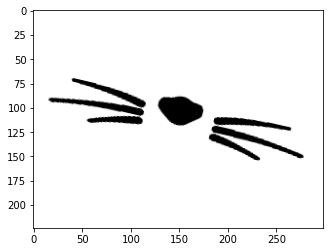

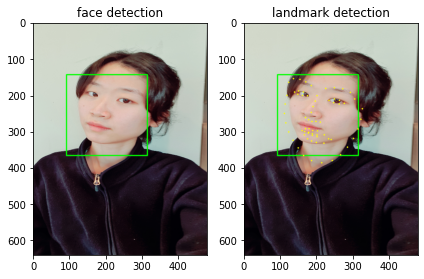

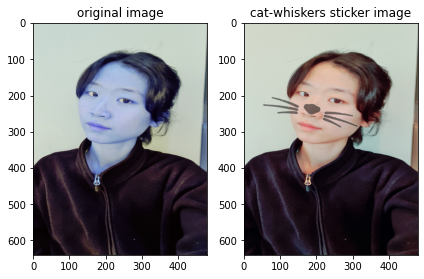

In [18]:
import cv2 #- 이미지 처리
import matplotlib.pyplot as plt #- 노트북에 이미지 출력
import numpy as np
import os
import dlib
import math 

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/side.png'
img_bgr = cv2.imread(my_image_path) 
img_bgr = cv2.resize(img_bgr, (480, 640)) 
img_origin=img_bgr.copy()
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detector_hog = dlib.get_frontal_face_detector() 
dlib_rects = detector_hog(img_rgb, 1) 

for dlib_rect in dlib_rects: 
    l = dlib_rect.left() 
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) #- cv2.rectangle(img, start, end, color, thickness)
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path) #- 인스턴스 생성 및 할당

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) #- 클래스 호출(image, box)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points): #- list_points는 랜드마크 좌표의 튜플리스트
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
        
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    
    x = landmark[30][0]
    y = landmark[30][1]
    
    w =  dlib_rect.width() + (landmark[30][0] - landmark[2][0])
    h =  dlib_rect.width() #- landmark[48][1]-landmark[36][1]
    
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)

img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)


#- 이미지 회전을 원합니다..! 
#- 추가된 코드의 설명은 아래에서..!

h1 = abs(landmark[36][1]-landmark[45][1]) 
w1 = abs(landmark[36][0]-landmark[45][0])

cp = ( img_sticker.shape[1]/2, img_sticker.shape[0]/2)
angle = (math.atan(h1/w1)/math.pi*180)
rot = cv2.getRotationMatrix2D(cp,-angle,0.9)
dst = cv2.warpAffine(img_sticker, rot, (0,0), borderValue=(255,255,255))
img_sticker = dst

plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()


plt.subplot(121)
plt.imshow(img_show_rgb)
plt.title('face detection')
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.title('landmark detection')
plt.tight_layout()
plt.show()

refined_x = x - w // 2  # left
refined_y = y - h //2     # top

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
elif refined_x < 0:
    img_sticker = img_sticker[-refined_x:]
    refined_x = 0

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker == 255, sticker_area,img_sticker).astype(np.uint8)


sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)


plt.subplot(121)
plt.imshow(img_origin)
plt.title('original image')
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.title('cat-whiskers sticker image')
plt.tight_layout()
plt.show()

#### 각도조절
아무런 조치를 취하지 않은 채 고양이 수염을 붙였을 때, 회전한 얼굴의 face detection 과 landmark 검출은 비교적 양호했지만,   
회전된 얼굴과 달리 고양이 수염 스티커는 회전하지 않아 부자연스러웠다.       
때문에 고양이수염 스티커를 얼굴에 자연스럽게 붙이기 위해서 고양이 수염 스티커를 회전시켰다.

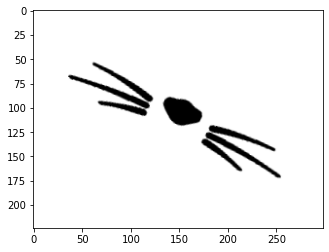

In [19]:
import math

h1 = abs(landmark[36][1]-landmark[45][1]) 
w1 = abs(landmark[36][0]-landmark[45][0])

cp = (img_sticker.shape[1]/2, img_sticker.shape[0]/2)
angle = (math.atan(h1/w1)/math.pi*180)
rot = cv2.getRotationMatrix2D(cp,-angle,0.9)
dst = cv2.warpAffine(img_sticker, rot, (0,0), borderValue=(255,255,255))
img_sticker = dst

plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

* 얼굴의 회전 각도 같이 고양이수염 스티커를 회전시키려 한다.
* 얼굴의 회전 각도(angle)는 두 눈 끝의 landmark[36]과 landmark[45]의 (x,y)좌표의 절댓값 차를 통해 도출한   
너비(w1)와 높이(h1)의 arctan 값을 통해 구했다.
* cv2.getRotationMatrix2D를 활용하여 img_sticker의 원점 축을 회전시켰다. 
* cv2.warpAffine를 활용하여 Aiffine transformation을 이미지에 적용시켰다.

* **cv.getRotationMatrix2D(	center, angle, scale	) ->	retval**  
Calculates an affine matrix of 2D rotation.  

    참고 : [getRotationMatrix2D()](https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#gafbbc470ce83812914a70abfb604f4326)
    
* **cv.warpAffine(	src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]]	) ->	dst**  
Applies an affine transformation to an image.  

    참고 : [cv.warpAffine()](https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#ga0203d9ee5fcd28d40dbc4a1ea4451983)

### 8-3 속도와 정확도
이미지 스티커 앱에서 실행 속도와 정확도는 당연히 중요한 요소일 것이다.   
만약 실행 속도와 정확도가 trade-off의 관계라고 한다면, 실행속도 : 정확도 = 35 : 65 정도로 볼 수 있을 것 같다.   
누구나 한번쯤은 포즈를 취하고 있을 때 사진기사가 머뭇머뭇하여 어색함을 느꼈던 경험이 있을 것이다. 사진촬영에서 신속함은 중요하다.  
하지만 아무리 실행 속도가 빨라도 정확하게 인물을 인식하여 스티커사진을 적용하지 못한다면 무용지물이기 때문에 정확도에 65점을, 신속도에 35점을 부여했다.  

---
## 9. 자가평가

Image Sticker App에서 얼굴이미지의 원근과 회전이라는 방해물에도 아랑곳 없이 얼굴을 찾아내어 랜드마크를 검출하고, 이미지 스티커를 적절히 적용하는 것은 매우 중요한 사안이다. 더불어 신속함도 무시할 수 없는 성능 평가의 중요한 요소이다. 요즘 스티커앱은 여러 사람이 인식될 경우 거뜬하게 모두에게 이미지 스티커를 적용하고, 얼굴이미지에 미세한 변화를 주기도하며, 두 사람의 얼굴을 바꿔놓기도 한다. 이미 이미지스티커앱의 기술력이 높아진 상황에서 앞으로 어떤 방향으로 발전할 수 있을지 궁금해진다.  
  
더 나아가 image detection 기술이 실생활에서 어떻게 활용될 수 있을지 고민해보게 되었다. image detection 기술은 사회문제해결에 활용될 가능성이 충분하다고 생각한다. 예를들어, 사회적 보호망 바깥의 소외계층은 도움이 필요하며 복지제도의 수혜대상임에도 수혜를 받지 못하고 있다. 즉 복지사각지대의 문제가 발생한다. 이같은 문제 발생 원인에는 다양한 요소가 있겠지만, 그 중 한가지는 소외계층의 특성상 사회와 어느정도 단절되어 있을 가능성이 높기 때문에, 소외계층을 직접 찾아나서는 것에는 한계가 있다. 복지전문가의 도움을 받아 소외계층의 주요한 특징들을 추출하여, image detection을 적용한다면 복지사각지대를 점차 줄여나갈 수도 있다는 생각이 든다. (예를 들어 폐지수거노인의 경우 커다란수레를 끌고 폐지와 각종 재활용품을 수거하며, 보통 나이대는 70대 이상이다.)   

하지만, image detection을 통해 일상에서 사람들을 분석한다는 것은 악용될 여지가 (매우)많기 때문에 조심스러운 부분이다. 어떻게 image detection이 긍정적인 방향으로 활용될 수 있을지는 깊이 고민해봐야 할 문제라고 생각한다. 


이번 프로젝트에서는 이해하기 어려웠던 코드를 낱낱이 파헤쳐서 기어코 이해해보았다. 그 과정을 쉽게 풀어내보려 노력했다.  
낯선 dlib와 openCV를 이해하기 위해 수없이 구글신을 찾아갔고.. 그는 답을 알려주었다.